In [11]:
# Install necessary libraries.

!pip install gymnasium
!pip install gymnasium[atari]
!pip install stable-baselines3[extra]
!pip install tensorflow
!pip install opencv-python

  Using cached Shimmy-0.2.1-py3-none-any.whl (25 kB)
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 1.3.0
    Uninstalling Shimmy-1.3.0:
      Successfully uninstalled Shimmy-1.3.0


In [14]:
# Import necessary libraries.

import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import StopTrainingOnRewardThreshold, EvalCallback
import torch as th
import cv2
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Set up the Atari environment

env = gym.make('Pong-v0')
env = DummyVecEnv([lambda: env])

In [32]:
from stable_baselines3.common.callbacks import BaseCallback

# Call back function to log data for plotting
class CustomCallback(BaseCallback):
    def __init__(self):
        super(CustomCallback, self).__init__()
        self.rewards = []
        self.episode_lengths = []
        self.local_ep_reward = 0
        self.local_ep_length = 0

    def _on_step(self) -> bool:
        self.local_ep_reward += self.locals['rewards']
        self.local_ep_length += 1
        if self.locals['dones'][0]:
            self.rewards.append(self.local_ep_reward)
            self.episode_lengths.append(self.local_ep_length)
            self.local_ep_reward = 0
            self.local_ep_length = 0
        return True


Using cpu device
Wrapping the env in a VecTransposeImage.
-----------------------------
| time/              |      |
|    fps             | 133  |
|    iterations      | 1    |
|    time_elapsed    | 15   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 2           |
|    time_elapsed         | 90          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011803755 |
|    clip_fraction        | 0.0976      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.78       |
|    explained_variance   | -0.0104     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0316      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00773    |
|    value_loss           | 1.01        |
------------------

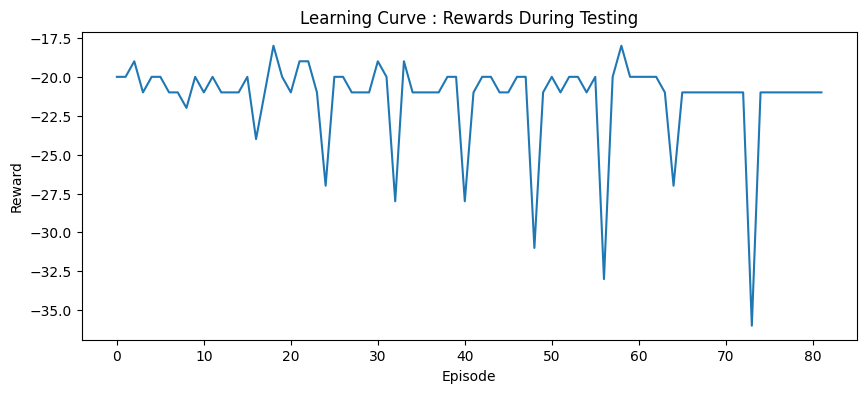

In [33]:
# Define the PPO model and train it

# Reference: https://medium.com/@shogulomkurganov73/atari-games-with-proximal-policy-optimization-ed28c7fafa3f

policy_kwargs = dict(net_arch=[dict(pi=[64, 64], vf=[64, 64])])
model = PPO("MlpPolicy", env, verbose=1, policy_kwargs=policy_kwargs)

stop_callback = StopTrainingOnRewardThreshold(reward_threshold=200, verbose=1)
eval_callback = EvalCallback(env, callback_on_new_best=stop_callback, eval_freq=10000, best_model_save_path='./best_model/', verbose=1)
custom_callback = CustomCallback()
model.learn(total_timesteps=100000, callback=[eval_callback, custom_callback])

# Save the model
model.save("pong_model")

rewards = custom_callback.rewards
episode_lengths = custom_callback.episode_lengths

print("Rewards:", rewards)
print("Episode lengths:", episode_lengths)

# Plotting the learning curve

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(rewards)
plt.title('Learning Curve : Rewards During Testing')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()


In [34]:
# Load the model for evaluation
model = PPO.load("pong_model", env=env)
evaluate_policy(model, env, n_eval_episodes=10, render=True)

Wrapping the env in a VecTransposeImage.


(-21.0, 0.0)